In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Zero-Shot Object Detection

In [2]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
import copy
import torchvision

In [3]:
class GraspDataset(Dataset):
    def __init__(self, folder_dir, transform=None):
        self.folder_dir = folder_dir
        self.transform = transform
        self.image_dir = os.path.join(folder_dir, 'image')
        self.ginstruction_dir = os.path.join(folder_dir, 'grasp_instructions')
        self.glabel_dir = os.path.join(folder_dir, 'grasp_label')

        self.samples = os.listdir(self.image_dir)
        self.samples = [sample[:-4] for sample in self.samples]

        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        instance = self.samples[idx]
        
        image_path = os.path.join(self.image_dir, instance + '.jpg')
        image = Image.open(image_path).convert('RGB')
        image = np.asarray(image).copy()
        
        ginstruction_path = os.path.join(self.ginstruction_dir, instance + '_0_0.pkl')
        with open(ginstruction_path, 'rb') as ff:
            ginstruction = pickle.load(ff)
        
        glabel_path = os.path.join(self.glabel_dir, instance + '_0_0.pt')
        with open(glabel_path, 'rb') as ff:
            glabel = torch.load(ff)

        if self.transform:
            image = self.transform(image)
        
        return image_path, image, ginstruction, glabel

In [4]:
folder = '../data/grasp-anything++/seen'
dataset = GraspDataset(folder)

### Testing

In [6]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2
from matplotlib import pyplot as plt

model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py", "GroundingDINO/groundingdino/groundingdino_swinb_cogcoor.pth")


final text_encoder_type: bert-base-uncased


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


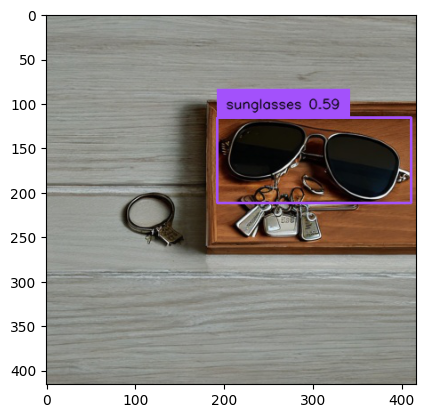

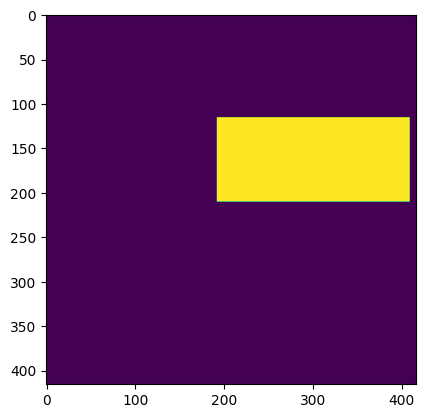

In [7]:
image_path, image, ginstruction, glabel = dataset.__getitem__(0)
IMAGE_PATH = image_path
TEXT_PROMPT = ginstruction
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.show()

def create_mask(image_source, boxes):
    mask = np.zeros_like(image_source[:,:,0])
    
    W, H, C = image_source.shape
    for box in boxes:
        unnormbbox = box * torch.Tensor([W, H, W, H])
        unnormbbox[:2] -= unnormbbox[2:] / 2
        [bbox_x, bbox_y, bbox_w, bbox_h] = unnormbbox.tolist()
        bbox_x, bbox_y, bbox_w, bbox_h = int(bbox_x), int(bbox_y), int(bbox_w), int(bbox_h)

        mask[bbox_y:bbox_y+bbox_h,bbox_x:bbox_x+bbox_w] = 1
    return mask
    
annotated_mask = create_mask(image_source, boxes)
plt.imshow(annotated_mask)
plt.show()

# Generating

In [35]:
def create_mask(image_source, boxes):
    mask = np.zeros_like(image_source[:,:,0])
    
    W, H, C = image_source.shape
    for box in boxes:
        unnormbbox = box * torch.Tensor([W, H, W, H])
        unnormbbox[:2] -= unnormbbox[2:] / 2
        [bbox_x, bbox_y, bbox_w, bbox_h] = unnormbbox.tolist()
        bbox_x, bbox_y, bbox_w, bbox_h = int(bbox_x), int(bbox_y), int(bbox_w), int(bbox_h)
        mask[bbox_y:bbox_y+bbox_h,bbox_x:bbox_x+bbox_w] = 1
    return mask

mask_dir = 'seen'
for idx in range(len(dataset)):

    image_path, image, ginstruction, glabel = dataset.__getitem__(idx)
    IMAGE_PATH = image_path
    TEXT_PROMPT = ginstruction
    BOX_TRESHOLD = 0.35
    TEXT_TRESHOLD = 0.25
    file_name = os.path.basename(image_path)[:-4]

    image_source, image = load_image(IMAGE_PATH)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    
    annotated_mask = create_mask(image_source, boxes)
    with open(os.path.join(mask_dir, file_name + '.npy'), 'wb') as file:
        np.save(file, annotated_mask)